<a href="https://colab.research.google.com/github/gusti-amber/udemy_pytorch/blob/main/lecture/lec4_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNNの実装
PyTorchでCNNの実装を行う。
また、データ拡張とドロップアウトの実装も行う。

# 1. CIFAR-10の読み込み
CIFARは約6万枚の画像にラベルをつけたたデータセット。各画像のサイズは32*32

以下のコードでは、CIFAR-10を読み込み、ランダムな25枚の画像を表示する。

In [1]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# cifar10をテストデータとして読み込み
cifar10_data = CIFAR10(root="./data",
                       train=False, download=True,
                       transform=transforms.ToTensor())
cifar10_classes = np.array(["airplane", "automobile", "bird", "cat", "deer",
                            "dog", "frog", "horse", "ship", "truck"])
print("データ数:", len(cifar10_data))

100%|██████████| 170M/170M [00:03<00:00, 44.0MB/s]


データ数: 10000


In [6]:
n_image = 25
# CIFAR-10から25枚ずつランダムに取り出すデータローダーの準備
cifar10_loader = DataLoader(cifar10_data, batch_size=n_image, shuffle=True)

# イテレータ（データを取り出す装置）の設定
dataiter = iter(cifar10_loader)

# 最初のバッチ（25枚の画像とラベル）を取り出す
images, labels = next(dataiter)

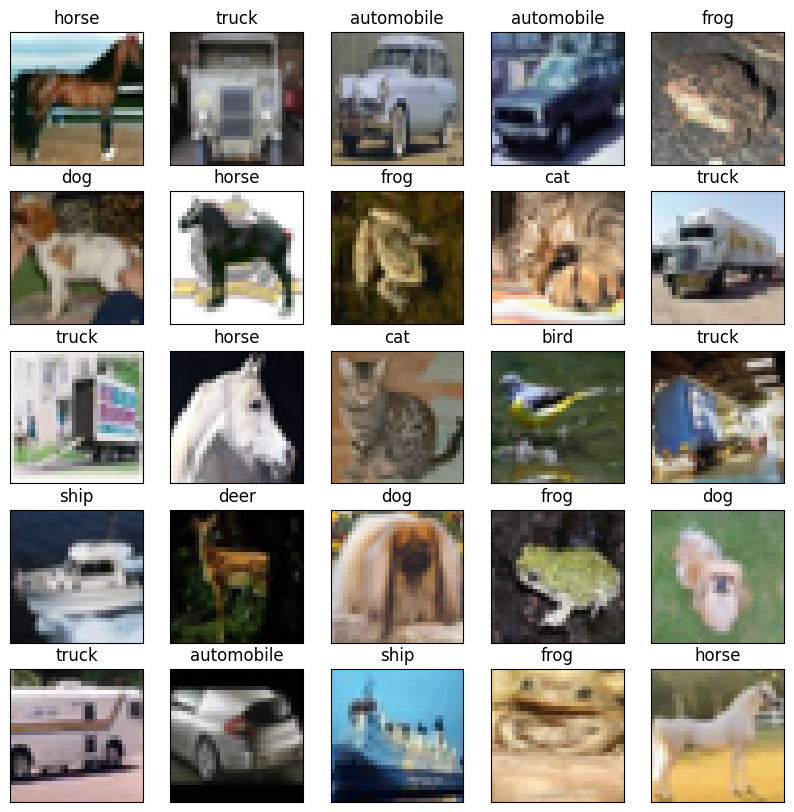

In [18]:
# 画像群の表示
plt.figure(figsize=(10,10)) # 画像の表示サイズを設定
for i in range(n_image):
  # 枠の表示
  plt.subplot(5,5,i+1)

  # 画像の表示
  # images[i]で出力される形式: (C,H,W)
  # plt.imshow()が期待する形式: (H,W,C)
  # np.transposeで形式の変換を行う
  plt.imshow(np.transpose(images[i], (1,2,0)))

  # ラベルの表示
  label = cifar10_classes[labels[i]]
  plt.title(label)

  # ラベルとメモリの非表示
  plt.tick_params(labelbottom=False,
                  labelleft=False,
                  bottom=False,
                  left=False)

plt.show()

# 2. データ拡張
torchvision.transformsを使ってデータ拡張を行う。

今回はcifar-10の画像に-30〜30°の回転、および0.8〜1.2倍のリサイズを行う。

データ数: 10000


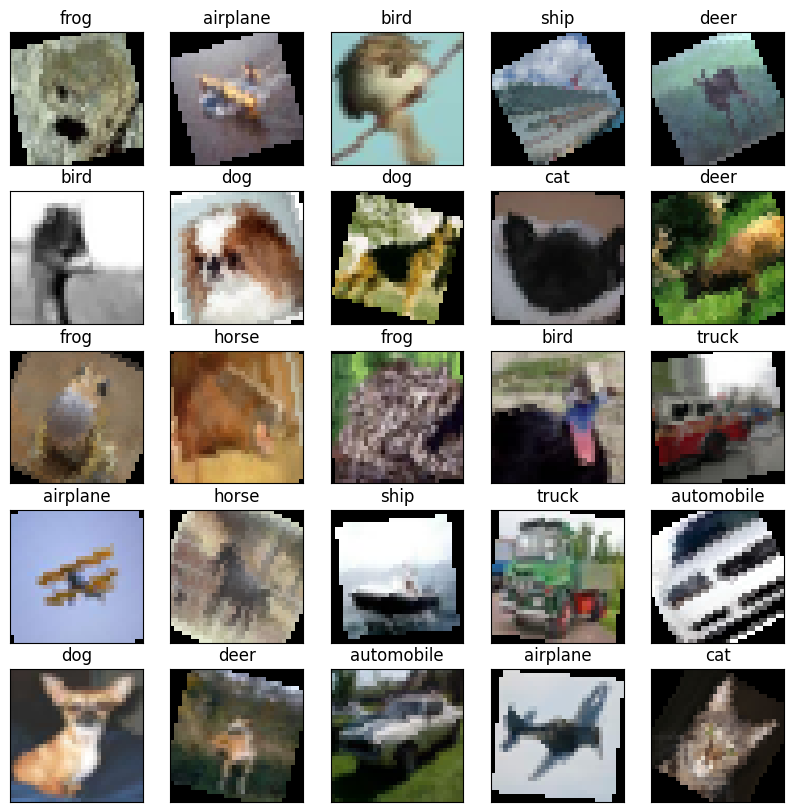

In [20]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# 前処理パイプライン（回転とリサイズ+テンソル変換）
transform = transforms.Compose([transforms.RandomAffine([-30,30], scale=(0.8,1.2)),
                                transforms.ToTensor()])

# cifar10をテストデータとして読み込み
cifar10_data = CIFAR10(root="./data",
                       train=False, download=True,
                       transform=transform)
cifar10_classes = np.array(["airplane", "automobile", "bird", "cat", "deer",
                            "dog", "frog", "horse", "ship", "truck"])
print("データ数:", len(cifar10_data))

n_image = 25
# CIFAR-10から25枚ずつランダムに取り出すデータローダーの準備
cifar10_loader = DataLoader(cifar10_data, batch_size=n_image, shuffle=True)

# イテレータ（データを取り出す装置）の設定
dataiter = iter(cifar10_loader)

# 最初のバッチ（25枚の画像とラベル）を取り出す
images, labels = next(dataiter)

# 画像群の表示
plt.figure(figsize=(10,10)) # 画像の表示サイズを設定
for i in range(n_image):
  # 枠の表示
  plt.subplot(5,5,i+1)

  # 画像の表示
  # images[i]で出力される形式: (C,H,W)
  # plt.imshow()が期待する形式: (H,W,C)
  # np.transposeで形式の変換を行う
  plt.imshow(np.transpose(images[i], (1,2,0)))

  # ラベルの表示
  label = cifar10_classes[labels[i]]
  plt.title(label)

  # ラベルとメモリの非表示
  plt.tick_params(labelbottom=False,
                  labelleft=False,
                  bottom=False,
                  left=False)

plt.show()

# 3. データの前処理
CNNの実装を行う。
データ拡張: 回転とリサイズ+左右反転
また、学習の効率化のため入力を標準化。

DataLoaderは、訓練データ・テストデータそれぞれ設定するが、テストデータにはミニバッチ法を適用しないので、バッチサイズは元データのサンプル数にする。

In [2]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 前処理パイプラインの設定
affine = transforms.RandomAffine([-15,15], scale=(0.8,1.2)) # 回転とリサイズ
flip = transforms.RandomHorizontalFlip(p=0.5) # 左右反転(確率:0.5)
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0)) # 標準化（平均値0, 標準偏差1）

transform_train = transforms.Compose([affine, flip, to_tensor, normalize])
transform_test = transforms.Compose([to_tensor, normalize])

# CIFAR10の読み込み
cifar10_train = CIFAR10("./data",
                        train=True,
                        download=True,
                        transform=transform_train)
cifar10_test = CIFAR10("./data",
                        train=False,
                        download=True,
                        transform=transform_test)

# DataLoaderの設定
batch_size = 64
train_loader = DataLoader(cifar10_train,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(cifar10_test,
                         batch_size=len(cifar10_test),
                         shuffle=False)

# 4. モデルの構築
nn.Moduleモジュールを継承したクラスとしてモデルを構築する。

今回は過学習を抑制するためにドロップアウトを導入する。

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()

    # 畳み込み層: (チャンネル数, フィルタ数, フィルタサイズ)
    # 入力画像: 32*32, 3ch(rgb)
    # フィルタ: 6枚, 5*5
    # パディング: 0, ストライド: 1
    # ↓
    # 出力画像: (32-5+2*0)/1+1=28, 28*28, 6ch
    self.conv1 = nn.Conv2d(3,6,5)

    # プール層: (領域サイズ, ストライド)
    # 入力画像: 28*28, 6ch
    # ストライド: 2
    # ↓
    # 出力画像: 28/2=14, 14*14, 6ch
    self.pool = nn.MaxPool2d(2,2)

    # 畳み込み層: (チャンネル数, フィルタ数, フィルタサイズ)
    # 入力画像: 14*14, 6ch
    # フィルタ: 16枚, 5*5
    # パディング: 0, ストライド: 1
    # ↓
    # 出力画像: (14-5+2*0)/1+1=10, 10*10, 16ch
    self.conv = nn.Conv2d(6,16,5)

    # プール層: (領域サイズ, ストライド)
    # 入力画像: 10*10, 16ch
    # ストライド: 2
    # ↓
    # 出力画像: 10/2=14, 5*5, 16ch

    self.fc1 = nn.Linear(16*5*5, 256) # 全結合層
    self.dropout = nn.Dropout(p=0.5) # ドロップアウト(確率:0.5)
    self.fc2 = nn.Linear(256, 10)

  def forward(self, x):
    # 畳み込み+プーリング
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))

    # NN
    x = x.view(-1, 16*5*5) # 平坦化
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.self.fc2(x)
    return x

net = Net()
net.cuda() # GPU対応
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


# 5. モデルの学習
DataLoaderによりミニバッチを取り出して訓練および評価を行う。
今回は評価時にミニバッチ法は使わず、テストデータ全体を使って一度に誤差を計算する。

In [ ]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters())

# 損失のログ
record_loss_train = []
record_loss_test = []